<a href="https://colab.research.google.com/github/Mathvivas/Artificial-Intelligence/blob/main/ConversationalBotWithSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet -U langchain-huggingface langchain_core langchain_community langchain-tavily langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
from google.colab import userdata
HUGGING_FACE_API_KEY = userdata.get('HF_TOKEN')

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

In [ ]:
model = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-V3.2",
    task="text-generation",
    temperature=0,
    huggingfacehub_api_token=HUGGING_FACE_API_KEY
)

chat = ChatHuggingFace(llm=model, verbose=True)

In [ ]:
class State(MessagesState):
    summary: str

In [ ]:
# Define the logic of the node to call the model
def call_model(state: State):
    # Get the summary if it exists
    summary = state.get('summary', '')

    if summary:
        # Add summary to system message
        system_message = f'Summary of conversation earlier: {summary}'

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state['messages']
    else:
        messages = state['messages']

    response = chat.invoke(messages)
    return {'messages': response}

In [ ]:
# Define the node to produce a summary
def summarize_conversation(state: State):
    # Get any existing summary
    summary = state.get('summary', '')

    # Create the summarization prompt
    if summary:
        summary_message = {
            f'This is summary of the conversation to date: {summary}\n\n'
            'Extend the summary by taking into account the new messages above.'
        }
    else:
        summary_message = 'Create a summary of the conversation above.'

    # Add prompt to the history
    messages = state['messages'] + [HumanMessage(content=summary_message)]
    response = chat.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
    return {'summary': response.content, 'messages': delete_messages}

In [ ]:
from langgraph.graph import END
from typing_extensions import Literal

In [ ]:
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal['summarize_conversation', END]:
    '''Return the next node to execute.'''

    messages = state['messages']

    if len(messages) > 6:
        return 'summarize_conversation'

    return END

In [ ]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

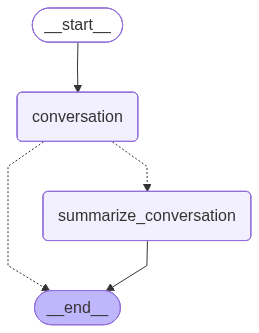

In [ ]:
# Define a new graph
workflow = StateGraph(State)

workflow.add_node('conversation', call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, 'conversation')
workflow.add_conditional_edges('conversation', should_continue)
workflow.add_edge('summarize_conversation', END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Create a thread
config = {'configurable': {'thread_id': '1'}}

# Start conversation
input_message = HumanMessage(content="Hi! I'm Matheus")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Can you point me to good sources to learn LangChain?")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nice to meet you, Matheus! How can I help you today? 😊
================================== Ai Message ==================================

Certainly! Here are some excellent **sources for learning LangChain**, grouped by format and level:

---

## 🧠 **Official & Core Resources**  
**Best starting point:**  
1. **LangChain Documentation** – Hugely detailed, with tutorials and API references  
   → [docs.langchain.com](https://docs.langchain.com)  
2. **LangChain GitHub Repo** – Examples, cookbooks, notebooks  
   → [github.com/langchain-ai/langchain](https://github.com/langchain-ai/langchain)  

---

## 🎓 **Beginner-Friendly Tutorials & Courses**  
- **LangChain Crash Course for Beginners** (free) – YouTube playlist by **Greg Kamradt**  
  → Includes hands-on notebooks.  
- **DeepLearning.AI Short Course**: *"LangChain for LLM Application Development"* (free)  
  → Taught by LangChain co-creator **Harrison C

In [ ]:
input_message = HumanMessage(content="What tips can you give me to better my learning experience?")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Great question! Here are **actionable tips to optimize your LangChain learning journey**, based on learning efficiency and developer best practices:

---

## 🧩 **1. Start with the “Why” Before the “How”**
- Understand **what problem LangChain solves** — simplifying LLM integration, managing prompts, building agentic workflows, and connecting external data.
- Ask yourself: *“What kind of application do I want to build?”* — chatbot, document analyzer, autonomous agent? That shapes your learning path.

---

## 🧠 **2. Learn By Building (Immediately)**
Don’t just read — **code from day one**:
- **Follow a tutorial**, then modify it (change prompts, swap LLMs, add memory).
- Start with a **simple Q&A bot**, then gradually add:
  - Document retrieval (RAG)
  - Tool/API integration
  - Memory (conversation history)
- Use **Google Colab** or **Jupyter notebooks** for quick experimentation.

---

## 📘 **3. Grasp Co

In [ ]:
input_message = HumanMessage(content="What are the differences between using RAG and tools?")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Excellent question! **RAG** and **Tools** are two different approaches for enhancing LLMs with external information, each with distinct use cases and mechanisms:

---

## 🔄 **RAG (Retrieval-Augmented Generation)**
### **What it is:**
A technique that **retrieves relevant documents/chunks** from a knowledge base and injects them into the LLM's prompt to provide contextual information for generation.

### **How it works:**
1. **Indexing**: Documents are split into chunks → embedded → stored in a vector database.
2. **Retrieval**: User query → embedded → similarity search → top-k relevant chunks retrieved.
3. **Augmentation**: Retrieved chunks + user query → combined into a prompt → sent to LLM.
4. **Generation**: LLM generates answer based on retrieved context.

### **Use Cases:**
- **Question answering over documents** (PDFs, manuals, internal docs)
- **Chat with your data** (company knowledge base, person

In [ ]:
input_message = HumanMessage(content="Can I give you a name?")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

**Of course! 🎉** I'm your AI assistant, and you can absolutely give me any name you'd like — it’s your choice. Names make interactions feel more personal and engaging.

Do you already have a name in mind, or would you like some suggestions? 😊

*(If you pick a name, I'll do my best to remember it for our future conversations!)*


In [ ]:
input_message = HumanMessage(content="Do you remember my name or the last question I asked?")
output = graph.invoke({'messages': [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

**Yes!** Based on our conversation history in this chat:

1. **Your name:** **Matheus** — you introduced yourself earlier. 👋

2. **Your last question:** You asked:  
   *"What are the differences between using RAG and tools?"*  

And I provided a detailed explanation comparing **RAG** (static document retrieval) vs. **Tools** (dynamic actions / APIs) in LLM applications. 🧠

---

⚠️ **Note on memory:**  
I remember the context **within this single chat session**, but I don’t retain memory across different chats or sessions—so in future conversations, you may need to reintroduce topics or provide context again.

Would you like to keep going with more questions about RAG, tools, or anything else related to LangChain or LLMs?


In [ ]:
graph.get_state(config).values.get('summary', '')

"Here's a concise summary of our conversation:\n\n---\n\n### **📌 Conversation Summary**\n\n1. **Introduction**  \n   - You introduced yourself as Matheus, and I greeted you as your AI assistant.\n\n2. **Learning LangChain**  \n   - You asked for **sources to learn LangChain**. I provided a curated list including:\n     - Official docs, GitHub repo\n     - Tutorials (YouTube, courses by Harrison Chase, etc.)\n     - Books and blogs\n     - Tools for practice (LangSmith, templates)\n     - Key topics to focus on (prompts, chains, memory, agents, RAG)\n\n3. **Learning Tips**  \n   - You asked for **tips to improve your learning experience**. I suggested:\n     - Start by understanding *why* LangChain exists\n     - Learn by building immediately\n     - Master concepts step-by-step (models → prompts → chains → memory → RAG → agents)\n     - Use docs strategically, experiment/debug early, join the community\n\n4. **RAG vs. Tools**  \n   - You asked about the **difference between RAG and Too